# Preamble

In [1]:
%matplotlib notebook

## Notebook parameters

In [2]:
NAME = 'a_6a_download_raw_filings' 
PROJECT = 'covid-empirical'
PYTHON_VERSION = '3.9'
USER = 'Ties'
CONDA_ENVIRONMENT = 'covid-empirical'
USE_EXTERNAL_PIPELINE = True

## Run preamble script

In [3]:
%run -i preamble.py 

----------------------------------------------------------------------------------
The following utility functions are loaded and available through `functions.<..>`:
----------------------------------------------------------------------------------

extract_data_edgar_link, fast_load_json, fast_store_json, flatten_multiindex_column, inDB, recreate_edgar_link

----------------------------------------------------------------
The following modules and functions are imported by preamble.py:
----------------------------------------------------------------

copy, delayed, importlib, json, math, np, orjson, os, pd, plt, pqdm_p, pqdm_t, random, re, requests, sys, time, yaml


## Notebook specific imports

In [4]:
from bs4 import BeautifulSoup
import html
import unidecode
from zipfile import ZipFile

### Set up spacy

In [5]:
import spacy

In [6]:
nlp = spacy.load('en_core_web_sm', disable = ['tok2vec', 'tagger' ,'parser' ,'attribute_ruler', 'lemmatizer', 'ner'])

------
# Logic
------

### Load the submission file for local lookup (takes about 2 minutes to load)

The submission file is downloaded from this page:

https://www.sec.gov/edgar/sec-api-documentation

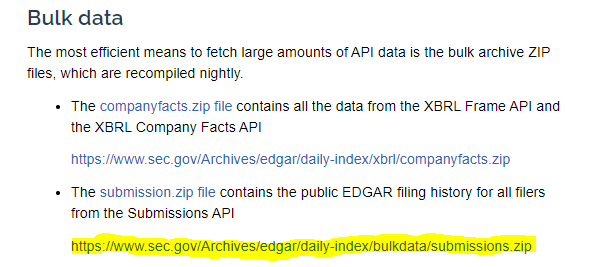

In [18]:
## After manually downloading the .zip file, identify the path and replace the one below.
## A relative path isn't practical here to avoid syncing this large .zip file to our Dropbox folder

submission_zipfile = r"F:\data_archive\submissions_03-25-2022.zip" 

submission_lookup = {}
with ZipFile(submission_zipfile, 'r') as archive:
    zip_files = archive.namelist()
    for file in tqdm(zip_files):
        try:
            submission_lookup[file] = orjson.loads(archive.read(file))
        except:
            pass

  0%|          | 0/795138 [00:00<?, ?it/s]

## Get filings

In [19]:
def get_filings(
    cik:str, 
    forms:list = ['10-K', '10-Q'], 
    cols_to_include:list = ['filingDate', 'reportDate', 'acceptanceDateTime', 'form', 'accessionNumber' , 'primaryDocument', 'size', 'isInlineXBRL'],
    parse_dates:bool = True, get_older:bool = True, include_link:bool = True, verbose:int = 0) -> pd.DataFrame:
    
    res_json  = submission_lookup['CIK{}.json'.format(cik)]
    
    ## Create a filing dataframe

    ### Newer filings

    filing_df = pd.DataFrame(res_json['filings']['recent'])

    ### Older filings
    
    if get_older:
        for i, json_link in enumerate(res_json['filings']['files']):
            res_files_json = submission_lookup[json_link['name']]
            older_filing_df = pd.DataFrame(res_files_json)
            filing_df = filing_df.append(older_filing_df)
        
    if verbose > 0:
        print('There are {} filings in the dataframe.'.format(len(filing_df.index)))

    ### Create a 10k/10q sub dataframe

    filing_df = filing_df[filing_df.form.isin(forms)]

    ### Create date column
    if parse_dates:
        filing_df['filingDate'] = pd.to_datetime(filing_df['filingDate'])
        filing_df['reportDate'] = pd.to_datetime(filing_df['reportDate'])
        
    ### Drop columns not needed
    filing_df = filing_df[cols_to_include]
    
    ### Add CIK
    filing_df['cik_padded'] = cik
    filing_df['cik'] = filing_df['cik_padded'].str.lstrip('0')
    
    ## Add link
    if include_link:
        filing_df['link'] = 'https://www.sec.gov/Archives/edgar/data/' + filing_df['cik'] + '/' + filing_df['accessionNumber'].str.replace('-', '') + '/'  + filing_df['primaryDocument']
    
    return filing_df

----------------------
# Run

### Params

In [20]:
attrs_to_keep=['href', 'style', 'id', 'name']
remove_tables=True
verbose = 1
parent_store_loc = ePipeline / 'store'
parent_store_loc = parent_store_loc.as_posix()

name = input(prompt = "Your name: ")
email = input(prompt = "Your email: ")
organization = input(prompt = "Your organization: ")
ua = f'{name} - {organization} - {email}' ## The SEC requires that you include this information in your user agent string

retrn = False 
cols_to_keep = ['filingDate', 'reportDate', 'acceptanceDateTime', 'form', 'accessionNumber' , 'primaryDocument', 'size', 'isInlineXBRL']

## Get CIK list

**Note:** downloading the filings will take a long time. The CIK list below is based on the full raw CIK list for all companies listed on EDGAR. Many of these companies do not make it into our final sample. This is not very efficient as a result, however, this is the most replicable way of coding it up.  

In [80]:
## See the code in `a_1_generate_filing_dataset` on how this Excel sheet was downloaded from WRDS.
wrds_df = pd.read_excel(Path.cwd() / '0_data' / 'external' / 'wrds_all_10qk_filings_07022022.xlsx')
wrds_df['cik'] = wrds_df['SEC Central Index Key'].apply(lambda x: str(x).zfill(10))

cik_list = list(wrds_df['cik'].unique())

In [22]:
filing_list = []
for cik in tqdm(cik_list):
    try:
        df = get_filings(cik, cols_to_include=cols_to_keep)
        df = df[df['reportDate'].dt.year >= 2017]
        df.reset_index(drop=True, inplace=True)
        df['uniqueID'] = df['link'].apply(lambda link: functions.extract_data_edgar_link(link)['uniqueID'])
        filing_list += df.to_dict('records')
        #for index, row in df.iterrows():
    except Exception as e:
        print(f'CIK: {cik} is not valid.')

  0%|          | 0/4565 [00:00<?, ?it/s]

In [23]:
filing_df = pd.DataFrame(filing_list)

In [28]:
len(filing_df.cik.unique())

4565

In [29]:
assert len(filing_df) == len(filing_df.uniqueID), 'The unique ID is not unique?'

In [30]:
filing_df.to_hdf(pipeline / 'out' / 'filing_df.h5', 'filing_df')

## Download filings

**WARNING:** Downloading all these filings can take up to a few days, will use a lot of bandwidth, and likely over 30gb over storage space. Only run if you need to. 

In [35]:
## Identify which filings are already done

raw_store_loc = ePipeline / 'out' / 'raw'
all_list = filing_df.uniqueID.to_list()
done_list = [x.name.replace('.json.gz', '') for x in raw_store_loc.glob('*.json.gz')]
todo_list = list(set(all_list).difference(set(done_list)))
todo_df = filing_df[filing_df.uniqueID.isin(todo_list)]
todo_df = todo_df.sample(len(todo_df.index))
print(f'Number todo: {len(todo_list)}, which is {len(todo_list) / len(all_list) * 100:.0f}% left to complete.')

Number todo: 0, which is 0% left to complete.


In [34]:
## Run

fail_list = []
for index, row in tqdm(todo_df.iterrows(), total = len(todo_df.index)):
    try:
        link = row['link']
        filing_dict = functions.extract_data_edgar_link(link)
        filename = row['uniqueID'] + '.json.gz'
        if not (raw_store_loc / filename).exists():
            res = requests.get(link, headers = {'User-Agent' : ua})
            if res.status_code == 200:
                raw_html = res.text
                functions.fast_store_json({'raw' : raw_html}, raw_store_loc / filename)
                time.sleep(0.1)
            else:
                raise Exception(status_code)
    except Exception as e:
        fail_list.append(link)

  0%|          | 0/7910 [00:00<?, ?it/s]